label ids =  [7, 11]
object_id =  7
 name =  road
object_id =  11
 name =  building


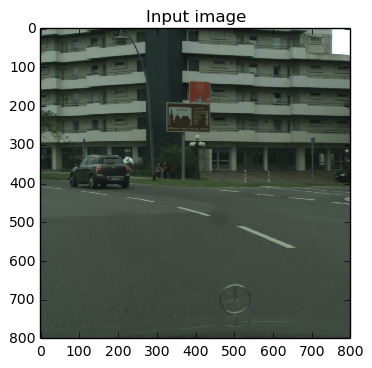

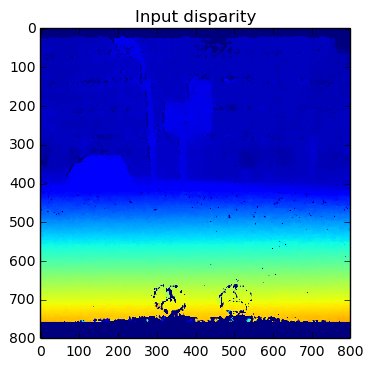

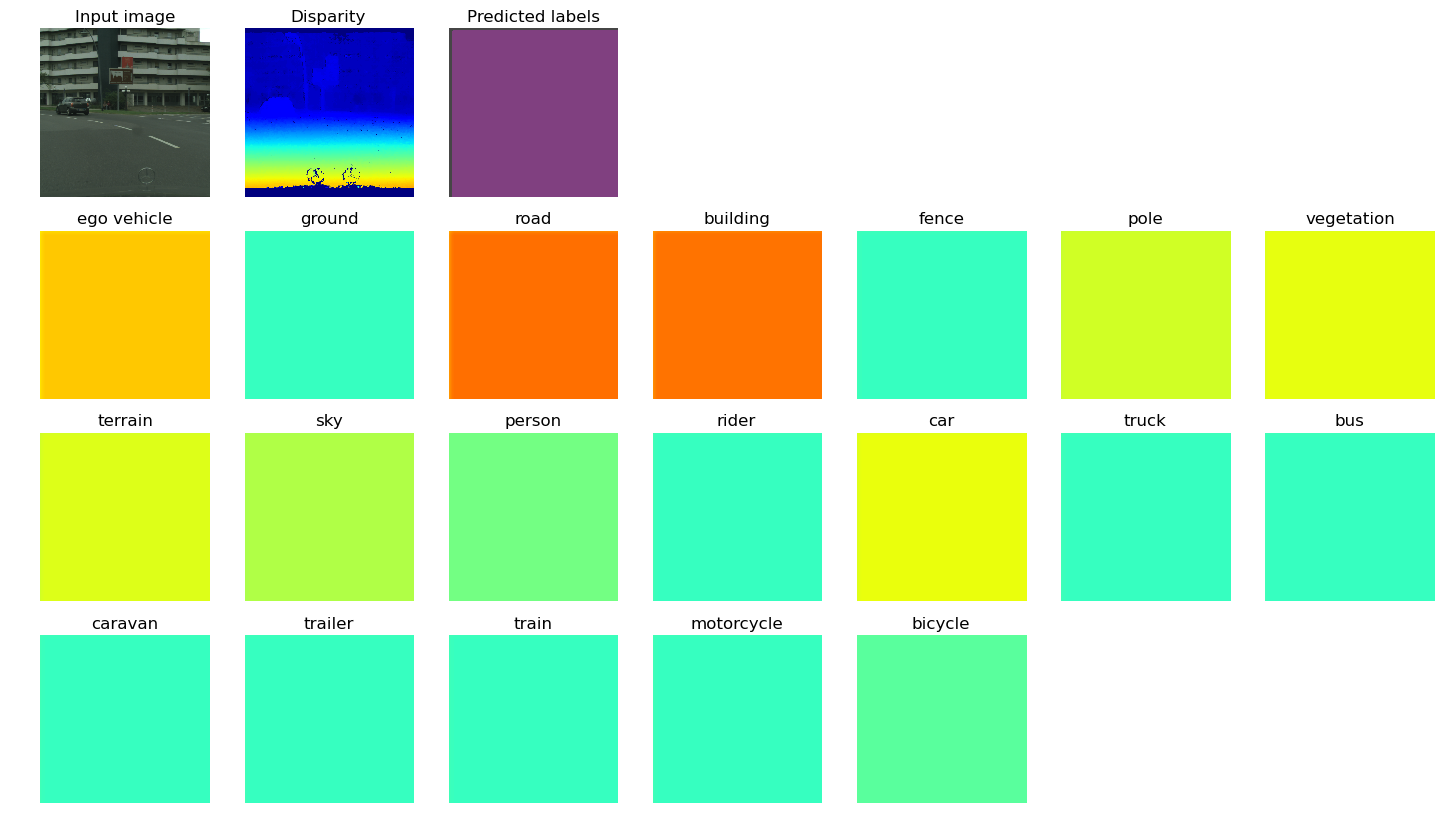

In [1]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import caffe
import os
import sys
import cv2
import glob

sys.path.insert(0, os.environ['CITYSCAPES_SCRIPTS'] + '/helpers')
import labels


def main():

    caffe.set_device(1)
    caffe.set_mode_gpu()

    # load the network
    net = caffe.Net('voc-fcn8s/deploy-scratch.prototxt', 'voc-fcn8s/snapshot/train_iter_4000.caffemodel', caffe.TEST)

    cityscapesPath = os.environ['CITYSCAPES_DATASET']
    search_test_images = os.path.join(cityscapesPath, 'leftImg8bit', 'test', '*', '*_leftImg8bit.png')
    search_test_disparity = os.path.join(cityscapesPath, 'disparity', 'test', '*', '*_disparity.png')

    test_images = glob.glob(search_test_images)
    test_disparity = glob.glob(search_test_disparity)

    test_images.sort()
    test_disparity.sort()

    # iterate over all test samples
    #for ind in range(len(test_images)):
    for ind in range(1):
        
        fname_img = '/media/ssd_drive/Cityscapes_dataset/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'
        fname_disp = '/media/ssd_drive/Cityscapes_dataset/disparity/train/aachen/aachen_000000_000019_disparity.png'

        img = prepare_input_image(fname_img, ind)
        disparity = prepare_input_disparity(fname_disp, ind)
        
        #img = prepare_input_image(test_images[ind], ind)
        #disparity = prepare_input_disparity(test_disparity[ind], ind)

        # input image
        plt.figure()
        plt.title('Input image')
        input_img = np.zeros(img.shape, dtype=np.uint8)
        input_img[:, :, 0] = img[:, :, 2]
        input_img[:, :, 1] = img[:, :, 1]
        input_img[:, :, 2] = img[:, :, 0]
        plt.imshow(input_img)
        
        # disparity map
        plt.figure()
        plt.title('Input disparity')
        plt.imshow(disparity)
        plt.clim(disparity.min(), disparity.max())
        
        #in_ = np.zeros((800, 800, 4), dtype=np.float32)
        #in_[:, :, 0] = np.float32(img[:, :, 0])
        #in_[:, :, 1] = np.float32(img[:, :, 1])
        #in_[:, :, 2] = np.float32(img[:, :, 2])
        #in_[:, :, 3] = disparity[:, :]
        #in_ = in_[:, :, ::-1]
        
        # create Caffe input data
        in_ = np.array(img, dtype=np.uint8)
        # in_ -= self.mean
        in_ = in_.transpose((2, 0, 1))
        
        # shape for input (data blob is N x C x H x W), set data
        net.blobs['data'].reshape(1, *in_.shape)
        net.blobs['data'].data[...] = in_

        # run the net and take argmax for prediction
        net.forward()
        out = net.blobs['score'].data[0].argmax(axis=0)        
        out = np.uint8(out)

        #print 'net.blobs = ', net.blobs['score'].data[0].shape
        #print 'net.blobs = ', net.blobs['score'].data[0].argmax(axis=0).shape
        #print 'out shape = ', out.shape

        label_ids = list(np.unique(out))
        print 'label ids = ', label_ids

        # heat maps for each class
        #plot_output_signals(img, net.blobs['score'].data[0])
        #continue

        #input_image = np.array(img, dtype=np.uint8)
        overlay = np.zeros(img.shape, dtype=np.uint8)

        for object_id in label_ids:
            
            print 'object_id = ', object_id
            print ' name = ', labels.id2label[object_id].name

            #  map from object_id to label
            #name = labels.trainId2label[object_id].name
            name = labels.id2label[object_id].name
            category = labels.id2label[object_id].category
            color = labels.id2label[object_id].color

            #print
            #print "Name of label with trainID '{id}': {name}".format(id=object_id, name=name)
            #print "   Category of label with ID '{id}': {category}".format(id=object_id, category=category)
            #print 'color = ', color

            object = np.zeros(img.shape, dtype=np.uint8)            
            indices = (out == object_id).nonzero()

            object[:, :, 0] = color[2]
            object[:, :, 1] = color[1]
            object[:, :, 2] = color[0]

            overlay[:, :, 0] += object[:, :, 0] * (out == object_id)
            overlay[:, :, 1] += object[:, :, 1] * (out == object_id)
            overlay[:, :, 2] += object[:, :, 2] * (out == object_id)

        #alpha = 0.6
        #cv2.addWeighted(overlay, alpha, img, 1.0-alpha, 0., img)

        # heat maps for each class
        plot_output_signals(ind, img, net.blobs['score'].data[0], overlay, disparity)


def plot_output_signals(index, img, output, overlay, disparity):

    # heat maps for each class
    #for i in range(output.shape[0]-1):
    #    class_name = labels.id2label[i].name
    #    print ' i = ', i, ', class_name = ', class_name

    #fig = plt.figure(figsize=(35, 20))
    fig = plt.figure(figsize=(18, 10))

    scale_min = -10.
    scale_max = 10.

    # subplot: rows x cols x plot number
    s_rows = 4
    s_cols = 7

    # input image
    plt.subplot(s_rows, s_cols, 1)
    plt.axis('off')
    plt.title('Input image')
    input_img = np.zeros(img.shape, dtype=np.uint8)
    input_img[:, :, 0] = img[:, :, 2]
    input_img[:, :, 1] = img[:, :, 1]
    input_img[:, :, 2] = img[:, :, 0]
    plt.imshow(input_img)

    # disparity map
    plt.subplot(s_rows, s_cols, 2)
    plt.axis('off')
    plt.title('Disparity')
    plt.imshow(disparity)
    plt.clim(disparity.min(), disparity.max())

    # predicted labels
    plt.subplot(s_rows, s_cols, 3)
    plt.axis('off')
    plt.title('Predicted labels')
    overlay_img = np.zeros(overlay.shape, dtype=np.uint8)
    overlay_img[:, :, 0] = overlay[:, :, 2]
    overlay_img[:, :, 1] = overlay[:, :, 1]
    overlay_img[:, :, 2] = overlay[:, :, 0]
    plt.imshow(overlay_img)

    # classes for heat map visualization
    list_classes = [1, 6, 7, 11, 13, 17, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
    s_number = s_cols + 1

    for class_ind in range(len(list_classes)):
        
        #print 'class_ind = ', class_ind
        #print 'class name = ', labels.id2label[list_classes[class_ind]].name
        
        #print 'min = ', output[list_classes[class_ind]].min()
        #print 'max = ', output[list_classes[class_ind]].max()
        
        plot_output_heat_map(s_rows, s_cols, s_number, output[list_classes[class_ind]],
                             labels.id2label[list_classes[class_ind]].name, scale_min, scale_max)
        s_number += 1

#    color_bar = plt.colorbar()
#    plt.setp(plt.getp(color_bar.ax.axes, 'yticklabels'), color='w')  # set colorbar
#    color_bar.outline.set_color('w')  # set colorbar box color
#    color_bar.ax.yaxis.set_tick_params(color='w')  # set colorbar ticks color

    plt.savefig('output/infer-final-' + str(index) + '.png', facecolor=fig.get_facecolor())
    #plt.close()


def plot_output_heat_map(row, col, number, data, title_str, scale_min, scale_max):

    plt.subplot(row, col, number)
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(data)
    plt.clim(scale_min, scale_max)
    #plt.clim(data.min(), data.max())


def plot_heat_map(title_str, data, scale_min, scale_max, fname):

    plt.figure(figsize=(20, 10))
    plt.title(title_str)
    plt.imshow(data)
    plt.clim(scale_min, scale_max)
    plt.colorbar()
    plt.savefig(fname + '.png')
    plt.close()


def prepare_input_image(fname, ind):
    """ Downscale and crop input image to a pre-defined size"""

    img = cv2.imread(fname, cv2.CV_LOAD_IMAGE_COLOR)
    height, width = img.shape[:2]

    height_new = 800
    width_new = int((width / float(height)) * height_new)
    dst = cv2.resize(img, (width_new, height_new), interpolation=cv2.INTER_NEAREST)

    middle_u = int(width_new / 2.)
    middle_v = int(height_new / 2.)
    cropped = dst[middle_v - 400:middle_v + 400, middle_u - 400:middle_u + 400]

    return cropped


def prepare_input_disparity(fname, ind):
    """ Downscale and crop input disparity map to a pre-defined size"""

    disparity = cv2.imread(fname, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    height, width = disparity.shape[:2]

    height_new = 800
    width_new = int((width / float(height)) * height_new)
    dst = cv2.resize(disparity, (width_new, height_new), interpolation=cv2.INTER_NEAREST)

    middle_u = int(width_new / 2.)
    middle_v = int(height_new / 2.)
    cropped = dst[middle_v - 400:middle_v + 400, middle_u - 400:middle_u + 400]

    return np.array(cropped, dtype=float)


if __name__ == "__main__":
    main()
